In [28]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/cleaned/ga_hta_socioeconomic_2024_clean.csv')
df['language'] = LabelEncoder().fit_transform(df['language'])
df = df.dropna().set_index('postcode')

# Split by canton (80% cantons to train, rest test)
canton_list = df['canton'].unique()
train_cantons = np.random.choice(canton_list, int(0.8 * len(canton_list)), replace=False)
test_cantons = [c for c in canton_list if c not in train_cantons]

# to ensure consistency in production
train_cantons = ['SG', 'BL', 'VS', 'OW', 'NE', 'GE', 'TG', 'BE', 'SH', 'LU', 'AG',
       'UR', 'GL', 'ZG', 'SO', 'AI', 'GR', 'TI', 'BS', 'SZ']
test_cantons = ['VD', 'FR', 'JU', 'NW', 'ZH', 'AR']

train_df = df[df['canton'].isin(train_cantons)]
test_df = df[df['canton'].isin(test_cantons)]

X_cols = [
    'num_stops', 'stop_density', 'avg_daily_frequency', 'max_stop_frequency',
    'population', 'male_population', 'swiss_citizen', 'married', 'age_20_64',
    'gdp_per_capita', 'eco_activity_rate', 'unemploy_rate',
    'total_residential_housing', 'pure_residential_single', 'pure_residential_multiple',
    'language'
]

X_train, y_train = train_df[X_cols], train_df[['GA_pct', 'HTA_pct']]
X_test, y_test = test_df[X_cols], test_df[['GA_pct', 'HTA_pct']]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = y_train
y_test_scaled = y_test

In [30]:
y_test

,GA_pct,HTA_pct
postcode,,
1000,2.192982,38.642659
1003,10.499852,59.656906
1004,5.194394,40.783272
1005,6.475515,51.288660
1006,8.402603,52.303628
...,...,...
9107,3.594898,33.745651
9410,3.673752,37.500000
9411,2.995720,29.814551


In [31]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

In [32]:
# linear regression
lrg = LinearRegression()
lrg.fit(X_train_scaled, y_train_scaled)
evaluate(lrg, X_test_scaled, y_test_scaled, "LinearRegressor")

LinearRegressor R²: 0.1745, MAE: 4.14, RMSE: 6.21


In [34]:
# ridge regression
rrg = Ridge(alpha=1.0)
rrg.fit(X_train_scaled, y_train_scaled)
evaluate(rrg, X_test_scaled, y_test_scaled, "RidgeRegressor")

RidgeRegressor R²: 0.1874, MAE: 4.14, RMSE: 6.22


In [36]:
# random forest
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=88))
rf.fit(X_train_scaled, y_train_scaled)
evaluate(rf, X_test_scaled, y_test_scaled, "RandomForest")

RandomForest R²: 0.0353, MAE: 4.34, RMSE: 6.46


In [27]:
# random forest finetuning
for i in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
    print(i)
    rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=i, random_state=88))
    rf.fit(X_train_scaled, y_train_scaled)
    evaluate(rf, X_test_scaled, y_test_scaled, "RandomForest")

10
RandomForest R²: -0.0861, MAE: 4.60, RMSE: 6.81
20
RandomForest R²: -0.0729, MAE: 4.45, RMSE: 6.60
50
RandomForest R²: 0.0353, MAE: 4.34, RMSE: 6.46
100
RandomForest R²: 0.0582, MAE: 4.37, RMSE: 6.50
200
RandomForest R²: 0.0667, MAE: 4.33, RMSE: 6.44
500
RandomForest R²: 0.0833, MAE: 4.28, RMSE: 6.36
1000
RandomForest R²: 0.0774, MAE: 4.26, RMSE: 6.33
2000
RandomForest R²: 0.0820, MAE: 4.27, RMSE: 6.34
5000
RandomForest R²: 0.0816, MAE: 4.27, RMSE: 6.35


In [38]:
# xgboost
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(random_state=88))
xgb_model.fit(X_train_scaled, y_train_scaled)
evaluate(xgb_model, X_test_scaled, y_test_scaled, "XGBoost")

XGBoost R²: -0.0070, MAE: 4.46, RMSE: 6.46


In [40]:
# lgbm
lgbm_model = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression_l2', random_state=88))
lgbm_model.fit(X_train_scaled, y_train_scaled)
evaluate(lgbm_model, X_test_scaled, y_test_scaled, "LightGBM")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 1433, number of used features: 16
[LightGBM] [Info] Start training from score 4.759621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 1433, number of used features: 16
[LightGBM] [Info] Start training from score 36.425118
LightGBM R²: 0.1447, MAE: 3.93, RMSE: 5.73


In [59]:
# catboost
cat_model = MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=88))
cat_model.fit(X_train_scaled, y_train_scaled)
evaluate(cat_model, X_test_scaled, y_test_scaled, "CatBoost")

CatBoost R²: 0.2868, MAE: 4.00, RMSE: 5.88


In [54]:
# mlp
mlp = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=32, activation='relu', max_iter=1000, random_state=88))
mlp.fit(X_train_scaled, y_train_scaled)
evaluate(mlp, X_test_scaled, y_test_scaled, "MLPRegressor")

MLPRegressor R²: -0.4632, MAE: 4.61, RMSE: 6.65


In [61]:
# SHAP

import shap

explainer = shap.Explainer(cat_model.predict, X_train_scaled)
shap_values = explainer(X_train_scaled)
shap_values.feature_names=X_cols

PermutationExplainer explainer: 1434it [08:09,  2.87it/s]                          


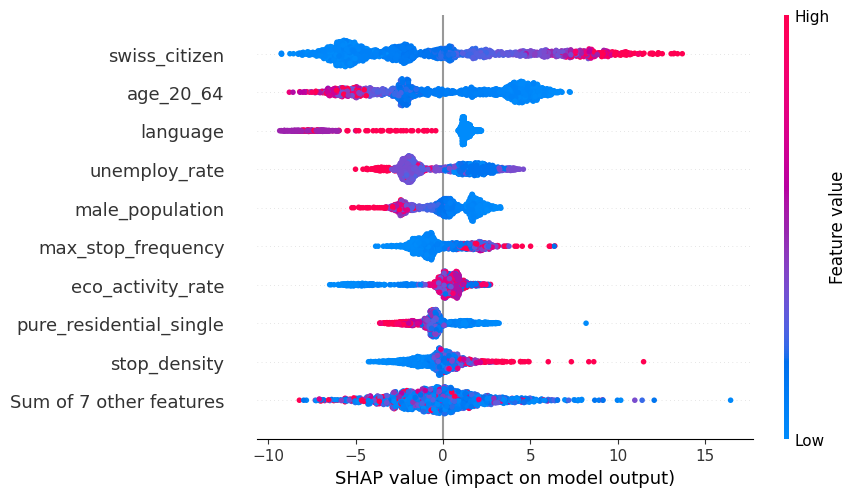

In [76]:
shap.plots.beeswarm(shap_values[:,:,1])

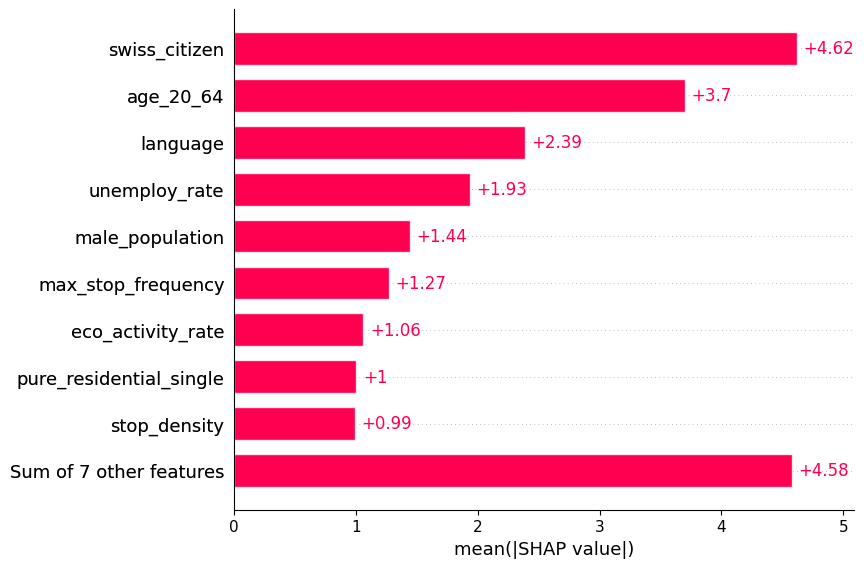

In [77]:
shap.plots.bar(shap_values[:,:,1])